<a href="https://colab.research.google.com/github/kkkaeun/AImodel/blob/main/Capstone_AImodel_3Real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Model
from keras.layers import Dense, Input, LSTM, GRU, Dropout, Conv1D
import tensorflow as tf

from tensorflow.python.framework.ops import disable_eager_execution
tf.compat.v1.keras.backend.clear_session()
disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [6]:
df_Course = pd.read_csv('/content/sample_data/120115_robot/ms25.csv', usecols=[7, 8, 9], header=None, names=['Gyro_x', 'Gyro_y', 'Gyro_z'])

df_GPS = pd.read_csv('/content/sample_data/120115_robot/nedgps.csv', header = None, names = ['North', 'East', 'Down'])
total_timestamps = len(df_GPS)
window_size = 20
start_point = 5
num_windows = total_timestamps - window_size + 1 - start_point

df = df_GPS.iloc[start_point:total_timestamps]
data = df[['North', 'East', 'Down']]

df_Accel = pd.read_csv('/content/sample_data/120115_robot/nedaccel.csv', header = None
                     , names = ['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED'])
df = df_Accel.iloc[start_point:total_timestamps]
data['Accel_x_NED'] = df['Accel_x_NED']
data['Accel_y_NED'] = df['Accel_y_NED']
data['Accel_z_NED'] = df['Accel_z_NED']

df_Euler = pd.read_csv('/content/sample_data/120115_robot/nedeuler.csv', header = None
                     , names = ['Euler_x', 'Euler_y', 'Euler_z'])
df = df_Euler.iloc[start_point:total_timestamps]
data['Euler_x'] = df['Euler_x']
data['Euler_y'] = df['Euler_y']
data['Euler_z'] = df['Euler_z']

df = df_Course.iloc[start_point:total_timestamps]
data['Gyro_x'] = df['Gyro_x']
data['Gyro_y'] = df['Gyro_y']
data['Gyro_z'] = df['Gyro_z']
data.tail()

,North,East,Down,Accel_x_NED,Accel_y_NED,Accel_z_NED,Euler_x,Euler_y,Euler_z,Gyro_x,Gyro_y,Gyro_z
320091,-1.6864,-2.4968,3.3991,-0.14228,-0.011752,9.8092,-135.81,0.006030,-0.67141,-0.004698,0.000619,-0.008716
320092,-1.6864,-2.4968,3.3991,-0.14165,-0.011759,9.8092,-135.82,0.007374,-0.66800,-0.002714,-0.005613,-0.001590
320093,-1.6863,-2.4968,3.3992,-0.14166,-0.012048,9.8092,-135.81,0.005780,-0.66744,-0.001513,-0.004799,0.004491
320094,-1.6861,-2.4968,3.3995,-0.14030,-0.013310,9.8093,-135.80,0.001955,-0.65727,-0.002847,-0.013433,0.005820
320095,-1.6858,-2.4967,3.4000,-0.13900,-0.016845,9.8093,-135.78,-0.014323,-0.64249,-0.002012,-0.008011,0.008690


In [8]:
#정답 레이블을 위한 GPS 변화량 데이터 만들기
delta_data = data.diff(axis=0)
delta_North = delta_data['North']
delta_East = delta_data['East']
delta_Down = delta_data['Down']

shifted = delta_data[['North', 'East', 'Down']].copy()

shifted['Pred_N'] = shifted['North'].shift(-window_size)
shifted['Pred_E'] = shifted['East'].shift(-window_size)
shifted['Pred_D'] = shifted['Down'].shift(-window_size)

shifted['Pred_N'].fillna(method='ffill', inplace = True)
shifted['Pred_E'].fillna(method='ffill', inplace = True)
shifted['Pred_D'].fillna(method='ffill', inplace = True)

In [9]:
train_X = data[['Accel_x_NED', 'Accel_y_NED',  'Accel_z_NED',  'Euler_x', 'Euler_y',  'Euler_z', 'Gyro_x', 'Gyro_y', 'Gyro_z']]
train_X = train_X.astype(np.float32)

windowed_data = np.zeros((num_windows, window_size, 9), dtype = np.float32)

for i in range(num_windows):
    windowed_data[i] = train_X[i:i+window_size]

train_y=shifted[['Pred_N', 'Pred_E', 'Pred_D']][:num_windows]

x_data = windowed_data
x_data = np.array(x_data)
y_data = train_y.values

print(x_data.shape)
print(y_data.shape)

(320072, 20, 9)
(320072, 3)


In [10]:
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

sc = MinMaxScaler(feature_range=(-1,1))

# 3D 배열을 2D로 변환
x_data_2d = x_data.reshape(-1, x_data.shape[-1])
y_data_2d = y_data.reshape(-1, y_data.shape[-1])

# 스케일링 적용
new_x_data_2d = sc.fit_transform(x_data_2d)
new_y_data_2d = sc.fit_transform(y_data_2d)

# 다시 3D로 변환
new_x_data = new_x_data_2d.reshape(x_data.shape)
new_y_data = new_y_data_2d.reshape(y_data.shape)

# train-test split
x_train, x_val, y_train, y_val = train_test_split(new_x_data, new_y_data, test_size=0.33, shuffle=True, random_state=42)

print(new_x_data.shape)
print(new_y_data.shape)

(320072, 20, 9)
(320072, 3)


In [11]:
from tensorflow.keras.optimizers import Adam
from keras.layers import MaxPooling1D

def Single_model():
    inp = Input(shape=(20, 9))
    x = Conv1D(filters=64, kernel_size=1, padding="causal", activation="relu", strides=1)(inp)
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'valid')(x)
    x = Conv1D(filters=128, kernel_size=1, padding="causal", activation="relu", strides=1)(x)
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'valid')(x)
    x = Conv1D(filters=256, kernel_size=1, padding="causal", activation="relu", strides=1)(x)
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'valid')(x)
    x = Conv1D(filters=512, kernel_size=1, padding="causal", activation="relu", strides=1)(x)
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'valid')(x)
    x = GRU(32, activation="tanh")(x)
    x = Dropout(0.3)(x)
    output = Dense(3, activation="linear")(x)

    model = Model(inputs=inp, outputs=output)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    model.summary()

    return model

if __name__ == "__main__":
    model = Single_model()

    history = model.fit(x_train, y_train, batch_size = 1024, epochs=10, validation_data=(x_val, y_val))

    y_pred = model.predict(x_val)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 9)]           0         
                                                                 
 conv1d (Conv1D)             (None, 20, 64)            640       
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 128)           8320      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 256)            33024 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


214448/214448 [==============================] - 93s 433us/sample - loss: 0.0011 - mae: 0.0222 - val_loss: 8.3860e-05 - val_mae: 0.0035
Epoch 2/10
214448/214448 [==============================] - 89s 414us/sample - loss: 3.9482e-04 - mae: 0.0135 - val_loss: 7.5026e-05 - val_mae: 0.0027
Epoch 3/10
214448/214448 [==============================] - 100s 464us/sample - loss: 2.4108e-04 - mae: 0.0097 - val_loss: 6.0914e-05 - val_mae: 0.0011
Epoch 4/10
214448/214448 [==============================] - 97s 451us/sample - loss: 1.5775e-04 - mae: 0.0070 - val_loss: 6.0293e-05 - val_mae: 0.0011
Epoch 5/10
214448/214448 [==============================] - 93s 435us/sample - loss: 1.1004e-04 - mae: 0.0050 - val_loss: 6.0362e-05 - val_mae: 0.0012
Epoch 6/10
214448/214448 [==============================] - 91s 424us/sample - loss: 8.3813e-05 - mae: 0.0036 - val_loss: 5.9380e-05 - val_mae: 7.5721e-04
Epoch 7/10
214448/214448 [==============================] - 88s 412us/sample - loss: 6.9131e-05 - mae: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


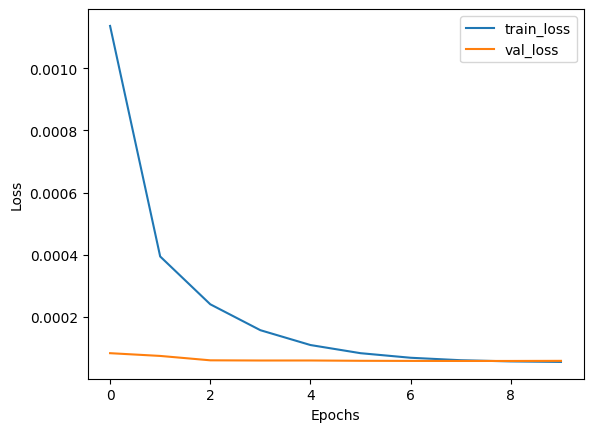

In [12]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**TEST 2. 120122 NCLT robot data**

**예측 구간: 70060 ~ 73060 (30s)**

In [13]:
df_Course2 = pd.read_csv('/content/sample_data/120122_robot/120122_ms25.csv', usecols=[7, 8, 9], header=None, names=['Gyro_x', 'Gyro_y', 'Gyro_z'])

df_GPS_TEST2 = pd.read_csv('/content/sample_data/120122_robot/120122_nedgps.csv', header = None, names = ['North', 'East', 'Down'])

TEST2_timestamps = 3020
window_size_TEST2 = 20
start_point_TEST2 = 70000
num_windows_TEST2 = TEST2_timestamps - window_size_TEST2 + 1

df_TEST2 = df_GPS_TEST2.iloc[start_point_TEST2:start_point_TEST2 + TEST2_timestamps]
data_TEST2 = df_TEST2[['North', 'East', 'Down']]

df_Accel_TEST2 = pd.read_csv('/content/sample_data/120122_robot/120122_nedaccel.csv', header = None
                     , names = ['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED'])
df_TEST2 = df_Accel_TEST2.iloc[start_point_TEST2:start_point_TEST2 + TEST2_timestamps]
data_TEST2['Accel_x_NED'] = df_TEST2['Accel_x_NED']
data_TEST2['Accel_y_NED'] = df_TEST2['Accel_y_NED']
data_TEST2['Accel_z_NED'] = df_TEST2['Accel_z_NED']

df_Euler_TEST2 = pd.read_csv('/content/sample_data/120122_robot/120122_nedeuler.csv', header = None
                     , names = ['Euler_x', 'Euler_y', 'Euler_z'])
df_TEST2 = df_Euler_TEST2.iloc[start_point_TEST2:start_point_TEST2 + TEST2_timestamps]
data_TEST2['Euler_x'] = df_TEST2['Euler_x']
data_TEST2['Euler_y'] = df_TEST2['Euler_y']
data_TEST2['Euler_z'] = df_TEST2['Euler_z']

df_TEST2 = df_Course2.iloc[start_point_TEST2:start_point_TEST2 + TEST2_timestamps]
data_TEST2['Gyro_x'] = df_TEST2['Gyro_x']
data_TEST2['Gyro_y'] = df_TEST2['Gyro_y']
data_TEST2['Gyro_z'] = df_TEST2['Gyro_z']
data_TEST2.tail()

,North,East,Down,Accel_x_NED,Accel_y_NED,Accel_z_NED,Euler_x,Euler_y,Euler_z,Gyro_x,Gyro_y,Gyro_z
73015,-5.7275,-9.5026,28.801,0.24857,0.19698,9.8185,160.37,2.1468,0.414850,0.064301,-0.114058,-0.218063
73016,-5.7273,-9.5024,28.800,0.20388,0.18402,9.8181,159.95,1.9333,0.247510,0.068128,-0.136164,-0.191499
73017,-5.7272,-9.5021,28.800,0.18658,0.16804,9.8174,159.58,1.7988,0.220110,0.066194,-0.146660,-0.180099
73018,-5.7272,-9.5017,28.800,0.15568,0.14832,9.8160,159.17,1.6003,0.141130,0.054493,-0.151170,-0.162591
73019,-5.7273,-9.5012,28.800,0.12430,0.12420,9.8163,158.85,1.3790,0.074867,0.033911,-0.161166,-0.111150


In [14]:
delta_data_TEST2 = data_TEST2.diff(axis=0)
delta_North_TEST2 = delta_data_TEST2['North']
delta_East_TEST2 = delta_data_TEST2['East']
delta_Down_TEST2 = delta_data_TEST2['Down']

shifted_TEST2 = delta_data_TEST2[['North', 'East', 'Down']].copy()
shifted_TEST2['Pred_N'] = shifted_TEST2['North'].shift(-window_size_TEST2)
shifted_TEST2['Pred_E'] = shifted_TEST2['East'].shift(-window_size_TEST2)
shifted_TEST2['Pred_D'] = shifted_TEST2['Down'].shift(-window_size_TEST2)

shifted_TEST2['Pred_N'].fillna(method='ffill', inplace = True)
shifted_TEST2['Pred_E'].fillna(method='ffill', inplace = True)
shifted_TEST2['Pred_D'].fillna(method='ffill', inplace = True)

In [16]:
train_X_TEST2 =  data_TEST2[['Accel_x_NED', 'Accel_y_NED',  'Accel_z_NED', 'Euler_x', 'Euler_y',  'Euler_z', 'Gyro_x', 'Gyro_y', 'Gyro_z']]
train_X_TEST2 = train_X_TEST2.astype(np.float32)

windowed_data_TEST2 = np.zeros((num_windows_TEST2, window_size_TEST2, 9), dtype = np.float32)

for i in range(num_windows_TEST2):
    windowed_data_TEST2[i] = train_X_TEST2[i:i+window_size_TEST2]

train_y_TEST2=shifted_TEST2[['Pred_N', 'Pred_E', 'Pred_D']][:num_windows_TEST2]

x_data_TEST2 = windowed_data_TEST2
x_data_TEST2 = np.array(x_data_TEST2)
y_data_TEST2 = train_y_TEST2.values

print(x_data_TEST2.shape)
print(y_data_TEST2.shape)

(3001, 20, 9)
(3001, 3)


In [17]:
x_data_TEST2 = x_data_TEST2.astype(np.float32)
y_data_TEST2 = y_data_TEST2.astype(np.float32)

sc_TEST2 = MinMaxScaler(feature_range=(-1,1))

# 3D 배열을 2D로 변환
x_data_2d_TEST2 = x_data_TEST2.reshape(-1, x_data_TEST2.shape[-1])
y_data_2d_TEST2 = y_data_TEST2.reshape(-1, y_data_TEST2.shape[-1])

# 스케일링 적용
new_x_data_2d_TEST2 = sc_TEST2.fit_transform(x_data_2d_TEST2)
new_y_data_2d_TEST2 = sc_TEST2.fit_transform(y_data_2d_TEST2)

# 다시 3D로 변환
new_x_data_TEST2 = new_x_data_2d_TEST2.reshape(x_data_TEST2.shape)
new_y_data_TEST2 = new_y_data_2d_TEST2.reshape(y_data_TEST2.shape)

print(new_x_data_TEST2.shape)
print(new_y_data_TEST2.shape)

(3001, 20, 9)
(3001, 3)


In [18]:
if __name__ == "__main__":

    y_pred_TEST2 = model.predict(new_x_data_TEST2)

In [19]:
import numpy as np

# 리스트를 NumPy 배열로 변환
y_preds_array_TEST2 = np.array(y_pred_TEST2)
new_y_data_array_TEST2 = np.array(new_y_data_TEST2)

# 3차원 배열을 2차원 배열로 변환
y_preds_flat_TEST2 = y_preds_array_TEST2.reshape(-1, y_preds_array_TEST2.shape[-1])
new_y_data_flat_TEST2 = new_y_data_array_TEST2.reshape(-1, new_y_data_array_TEST2.shape[-1])

# 예측값의 스케일을 되돌리기 위한 역변환
rescaled_y_preds_N_E_TEST2 = sc_TEST2.inverse_transform(y_preds_flat_TEST2)
rescaled_y_test_actual_N_E_TEST2 = sc_TEST2.inverse_transform(new_y_data_flat_TEST2)

# 위도와 경도값만 가져오기
predicted_North_TEST2 = rescaled_y_preds_N_E_TEST2[:, 0]
predicted_East_TEST2 = rescaled_y_preds_N_E_TEST2[:, 1]

actual_North_TEST2 = rescaled_y_test_actual_N_E_TEST2[:, 0]
actual_East_TEST2 = rescaled_y_test_actual_N_E_TEST2[:, 1]

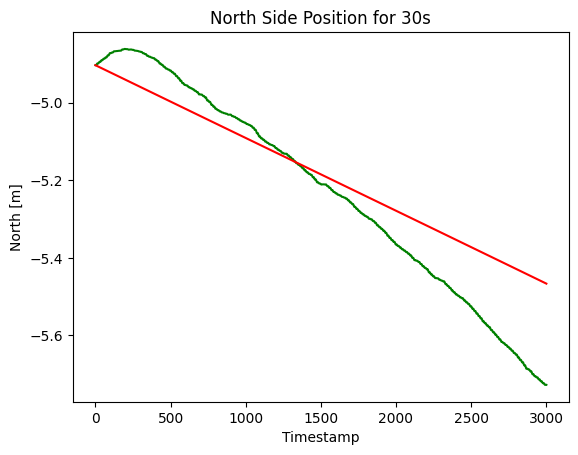

In [20]:
# 초기값 설정
initial_North = data_TEST2['North'][70020]

# 실제 latitude 추정치 계산
North_predicted_TEST2 = [initial_North]
for change in predicted_North_TEST2:
    new_North_TEST2 = North_predicted_TEST2[-1] + change
    North_predicted_TEST2.append(new_North_TEST2)

# 실제 latitude 추정치 계산
North_actual_TEST2 = [initial_North]
for change in actual_North_TEST2:
    new_North_TEST2 = North_actual_TEST2[-1] + change
    North_actual_TEST2.append(new_North_TEST2)

# 시각화
plt.plot(North_actual_TEST2, label='Actual', c='g')
plt.plot(North_predicted_TEST2, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('North [m]')
plt.title('North Side Position for 30s')
plt.show()

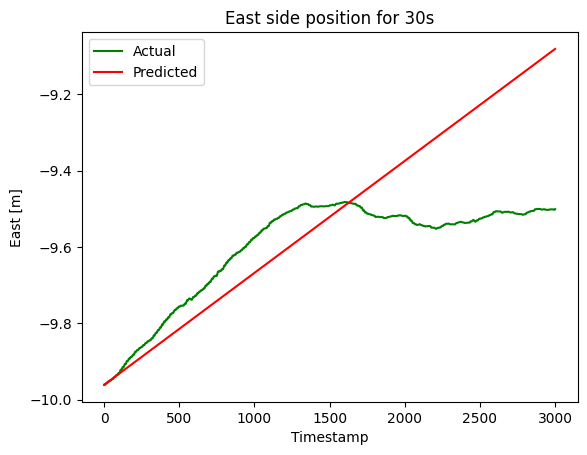

In [21]:
# 초기값 설정
initial_East = data_TEST2['East'][70020]

# 실제 latitude 추정치 계산
East_predicted_TEST2 = [initial_East]
for change in predicted_East_TEST2:
    new_East_TEST2 = East_predicted_TEST2[-1] + change
    East_predicted_TEST2.append(new_East_TEST2)

# 실제 latitude 추정치 계산
East_actual_TEST2 = [initial_East]
for change in actual_East_TEST2:
    new_East_TEST2 = East_actual_TEST2[-1] + change
    East_actual_TEST2.append(new_East_TEST2)

# 시각화
plt.plot(East_actual_TEST2, label='Actual', c='g')
plt.plot(East_predicted_TEST2, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('East [m]')
plt.title('East side position for 30s')
plt.legend()
plt.show()

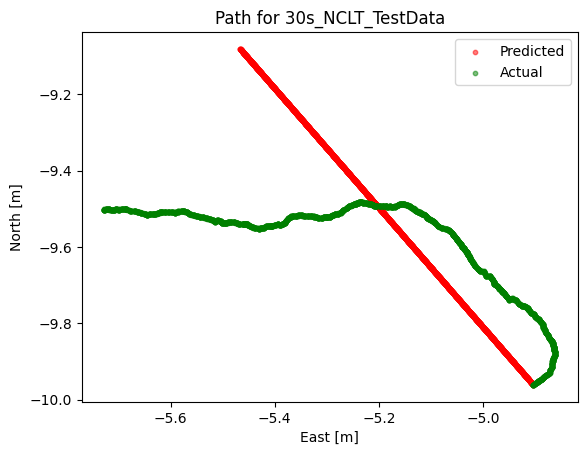

In [45]:
plt.scatter(x=North_predicted_TEST2, y=East_predicted_TEST2, label='Predicted', c='r', s=10, alpha=0.5)
plt.scatter(x=North_actual_TEST2, y=East_actual_TEST2, label='Actual', c='g', s=10, alpha=0.5)
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.title('Path for 30s_NCLT_TestData')
plt.legend()
plt.show()

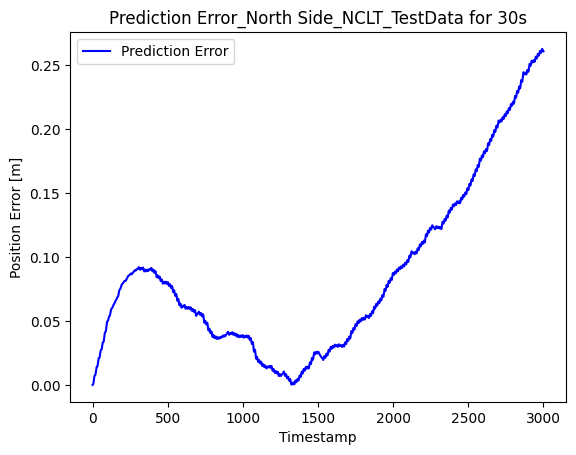

SE: 0.261 m
RMSE: 0.109 m


In [47]:
East_actual_TEST2 = np.array(East_actual_TEST2)
North_actual_TEST2 = np.array(North_actual_TEST2)
East_predicted_TEST2 = np.array(East_predicted_TEST2)
North_predicted_TEST2 = np.array(North_predicted_TEST2)

SE_TEST2 = np.sqrt((North_actual_TEST2 - North_predicted_TEST2) ** 2)
RMSE_TEST2 = np.sqrt(np.mean((North_actual_TEST2 - North_predicted_TEST2) ** 2))

time_steps_TEST2 = np.arange(len(SE_TEST2))

plt.plot(time_steps_TEST2, SE_TEST2, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_North Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

print('SE: {:.3f} m'.format(SE_TEST2[-1]))
print('RMSE: {:.3f} m'.format(RMSE_TEST2))

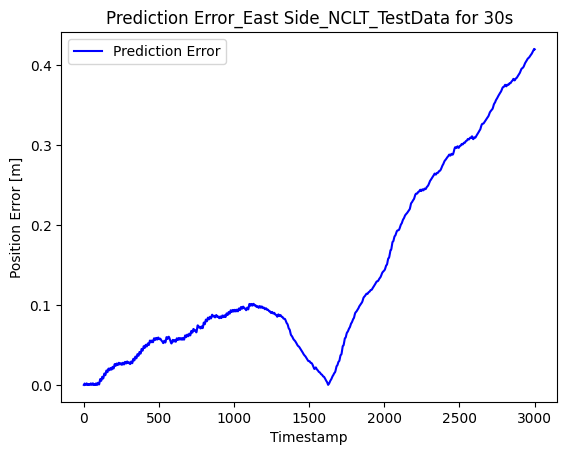

SE: 0.420 m
RMSE: 0.185 m


In [48]:
SE_TEST2 = np.sqrt((East_actual_TEST2 - East_predicted_TEST2) ** 2)
RMSE_TEST2 = np.sqrt(np.mean((East_actual_TEST2 - East_predicted_TEST2) ** 2))

time_steps_TEST2 = np.arange(len(SE_TEST2))

plt.plot(time_steps_TEST2, SE_TEST2, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_East Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

print('SE: {:.3f} m'.format(SE_TEST2[-1]))
print('RMSE: {:.3f} m'.format(RMSE_TEST2))

**TEST 3. 120122 NCLT robot data**

**예측 구간: 100560 ~103560 (30s)**

In [25]:
df_Course3 = pd.read_csv('/content/sample_data/120122_robot/120122_ms25.csv', usecols=[7, 8, 9], header=None, names=['Gyro_x', 'Gyro_y', 'Gyro_z'])

df_GPS_TEST3 = pd.read_csv('/content/sample_data/120122_robot/120122_nedgps.csv', header = None, names = ['North', 'East', 'Down'])

TEST3_timestamps = 3020
window_size_TEST3 = 20
start_point_TEST3 = 100500
num_windows_TEST3 = TEST3_timestamps - window_size_TEST3 + 1

df_TEST3 = df_GPS_TEST3.iloc[start_point_TEST3:start_point_TEST3 + TEST3_timestamps]
data_TEST3 = df_TEST3[['North', 'East', 'Down']]

df_Accel_TEST3 = pd.read_csv('/content/sample_data/120122_robot/120122_nedaccel.csv', header = None
                     , names = ['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED'])
df_TEST3 = df_Accel_TEST3.iloc[start_point_TEST3:start_point_TEST3 + TEST3_timestamps]
data_TEST3['Accel_x_NED'] = df_TEST3['Accel_x_NED']
data_TEST3['Accel_y_NED'] = df_TEST3['Accel_y_NED']
data_TEST3['Accel_z_NED'] = df_TEST3['Accel_z_NED']

df_Euler_TEST3 = pd.read_csv('/content/sample_data/120122_robot/120122_nedeuler.csv', header = None
                     , names = ['Euler_x', 'Euler_y', 'Euler_z'])
df_TEST3 = df_Euler_TEST3.iloc[start_point_TEST3:start_point_TEST3 + TEST3_timestamps]
data_TEST3['Euler_x'] = df_TEST3['Euler_x']
data_TEST3['Euler_y'] = df_TEST3['Euler_y']
data_TEST3['Euler_z'] = df_TEST3['Euler_z']

df_TEST3 = df_Course3.iloc[start_point_TEST3:start_point_TEST3 + TEST3_timestamps]
data_TEST3['Gyro_x'] = df_TEST3['Gyro_x']
data_TEST3['Gyro_y'] = df_TEST3['Gyro_y']
data_TEST3['Gyro_z'] = df_TEST3['Gyro_z']
data_TEST3.head()

,North,East,Down,Accel_x_NED,Accel_y_NED,Accel_z_NED,Euler_x,Euler_y,Euler_z,Gyro_x,Gyro_y,Gyro_z
100500,-3.8487,-14.560,15.897,-0.86234,0.028358,9.7839,136.28,-2.4425,-4.2750,-0.026605,-0.017455,-0.131958
100501,-3.8482,-14.560,15.891,-0.89129,0.059598,9.7819,136.23,-2.3933,-4.5190,0.006880,-0.015868,-0.148584
100502,-3.8475,-14.559,15.889,-0.91886,0.079068,9.7768,136.10,-2.3959,-4.7177,0.049845,-0.017830,-0.163415
100503,-3.8467,-14.559,15.889,-0.95516,0.090152,9.7706,135.91,-2.4682,-4.9298,0.086580,-0.011397,-0.173146
100504,-3.8459,-14.558,15.891,-0.98511,0.084474,9.7661,135.70,-2.5980,-5.0541,0.108856,-0.013439,-0.148482


In [26]:
delta_data_TEST3 = data_TEST3.diff(axis=0)
delta_North_TEST3 = delta_data_TEST3['North']
delta_East_TEST3 = delta_data_TEST3['East']
delta_Down_TEST3 = delta_data_TEST3['Down']

shifted_TEST3 = delta_data_TEST3[['North', 'East', 'Down']].copy()
shifted_TEST3['Pred_N'] = shifted_TEST3['North'].shift(-window_size_TEST3)
shifted_TEST3['Pred_E'] = shifted_TEST3['East'].shift(-window_size_TEST3)
shifted_TEST3['Pred_D'] = shifted_TEST3['Down'].shift(-window_size_TEST3)

shifted_TEST3['Pred_N'].fillna(method='ffill', inplace = True)
shifted_TEST3['Pred_E'].fillna(method='ffill', inplace = True)
shifted_TEST3['Pred_D'].fillna(method='ffill', inplace = True)

In [27]:
train_X_TEST3 =  data_TEST3[['Accel_x_NED', 'Accel_y_NED',  'Accel_z_NED', 'Euler_x', 'Euler_y',  'Euler_z', 'Gyro_x', 'Gyro_y', 'Gyro_z']]
train_X_TEST3 = train_X_TEST3.astype(np.float32)

windowed_data_TEST3 = np.zeros((num_windows_TEST3, window_size_TEST3, 9), dtype = np.float32)

for i in range(num_windows_TEST3):
    windowed_data_TEST3[i] = train_X_TEST3[i:i+window_size_TEST3]

train_y_TEST3=shifted_TEST3[['Pred_N', 'Pred_E', 'Pred_D']][:num_windows_TEST3]

x_data_TEST3 = windowed_data_TEST3
x_data_TEST3 = np.array(x_data_TEST3)
y_data_TEST3 = train_y_TEST3.values

print(x_data_TEST3.shape)
print(y_data_TEST3.shape)

(3001, 20, 9)
(3001, 3)


In [28]:
x_data_TEST3 = x_data_TEST3.astype(np.float32)
y_data_TEST3 = y_data_TEST3.astype(np.float32)

sc_TEST3 = MinMaxScaler(feature_range=(-1,1))

# 3D 배열을 2D로 변환
x_data_2d_TEST3 = x_data_TEST3.reshape(-1, x_data_TEST3.shape[-1])
y_data_2d_TEST3 = y_data_TEST3.reshape(-1, y_data_TEST3.shape[-1])

# 스케일링 적용
new_x_data_2d_TEST3 = sc_TEST3.fit_transform(x_data_2d_TEST3)
new_y_data_2d_TEST3 = sc_TEST3.fit_transform(y_data_2d_TEST3)

# 다시 3D로 변환
new_x_data_TEST3 = new_x_data_2d_TEST3.reshape(x_data_TEST3.shape)
new_y_data_TEST3 = new_y_data_2d_TEST3.reshape(y_data_TEST3.shape)

print(new_x_data_TEST3.shape)
print(new_y_data_TEST3.shape)

(3001, 20, 9)
(3001, 3)


In [29]:
if __name__ == "__main__":

    y_pred_TEST3 = model.predict(new_x_data_TEST3)

In [30]:
import numpy as np

# 리스트를 NumPy 배열로 변환
y_preds_array_TEST3 = np.array(y_pred_TEST3)
new_y_data_array_TEST3 = np.array(new_y_data_TEST3)

# 3차원 배열을 2차원 배열로 변환
y_preds_flat_TEST3 = y_preds_array_TEST3.reshape(-1, y_preds_array_TEST3.shape[-1])
new_y_data_flat_TEST3 = new_y_data_array_TEST3.reshape(-1, new_y_data_array_TEST3.shape[-1])

# 예측값의 스케일을 되돌리기 위한 역변환
rescaled_y_preds_N_E_TEST3 = sc_TEST3.inverse_transform(y_preds_flat_TEST3)
rescaled_y_test_actual_N_E_TEST3 = sc_TEST3.inverse_transform(new_y_data_flat_TEST3)

# 위도와 경도값만 가져오기
predicted_North_TEST3 = rescaled_y_preds_N_E_TEST3[:, 0]
predicted_East_TEST3 = rescaled_y_preds_N_E_TEST3[:, 1]

actual_North_TEST3 = rescaled_y_test_actual_N_E_TEST3[:, 0]
actual_East_TEST3 = rescaled_y_test_actual_N_E_TEST3[:, 1]

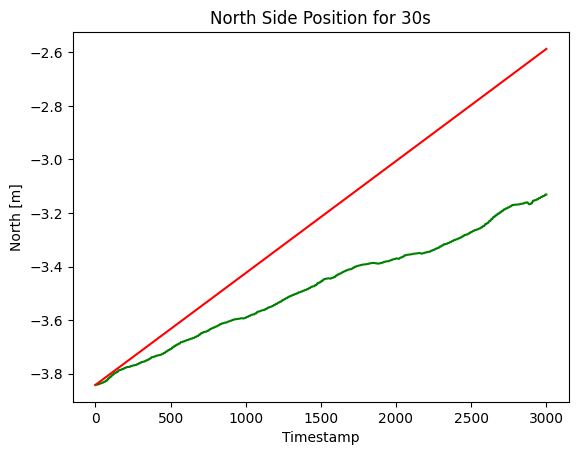

In [31]:
# 초기값 설정
initial_North = data_TEST3['North'][100520]

# 실제 latitude 추정치 계산
North_predicted_TEST3 = [initial_North]
for change in predicted_North_TEST3:
    new_North_TEST3 = North_predicted_TEST3[-1] + change
    North_predicted_TEST3.append(new_North_TEST3)

# 실제 latitude 추정치 계산
North_actual_TEST3 = [initial_North]
for change in actual_North_TEST3:
    new_North_TEST3 = North_actual_TEST3[-1] + change
    North_actual_TEST3.append(new_North_TEST3)

# 시각화
plt.plot(North_actual_TEST3, label='Actual', c='g')
plt.plot(North_predicted_TEST3, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('North [m]')
plt.title('North Side Position for 30s')
plt.show()

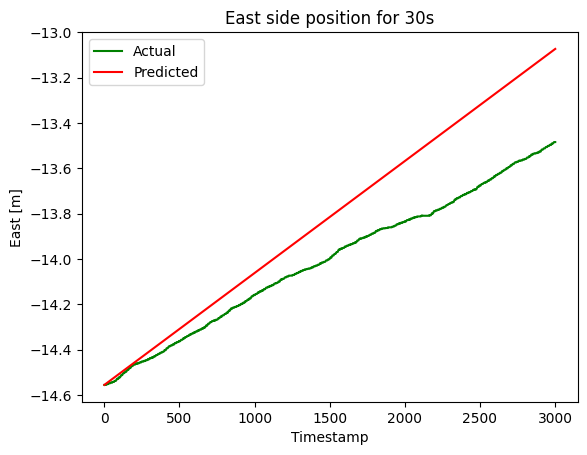

In [32]:
# 초기값 설정
initial_East = data_TEST3['East'][100520]

# 실제 latitude 추정치 계산
East_predicted_TEST3 = [initial_East]
for change in predicted_East_TEST3:
    new_East_TEST3 = East_predicted_TEST3[-1] + change
    East_predicted_TEST3.append(new_East_TEST3)

# 실제 latitude 추정치 계산
East_actual_TEST3 = [initial_East]
for change in actual_East_TEST3:
    new_East_TEST3 = East_actual_TEST3[-1] + change
    East_actual_TEST3.append(new_East_TEST3)

# 시각화
plt.plot(East_actual_TEST3, label='Actual', c='g')
plt.plot(East_predicted_TEST3, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('East [m]')
plt.title('East side position for 30s')
plt.legend()
plt.show()

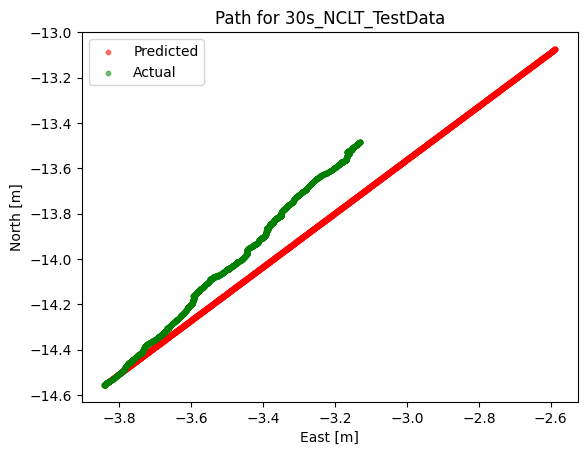

In [46]:
plt.scatter(x=North_predicted_TEST3, y=East_predicted_TEST3, label='Predicted', c='r', s=10, alpha=0.5)
plt.scatter(x=North_actual_TEST3, y=East_actual_TEST3, label='Actual', c='g', s=10, alpha=0.5)
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.title('Path for 30s_NCLT_TestData')
plt.legend()
plt.show()

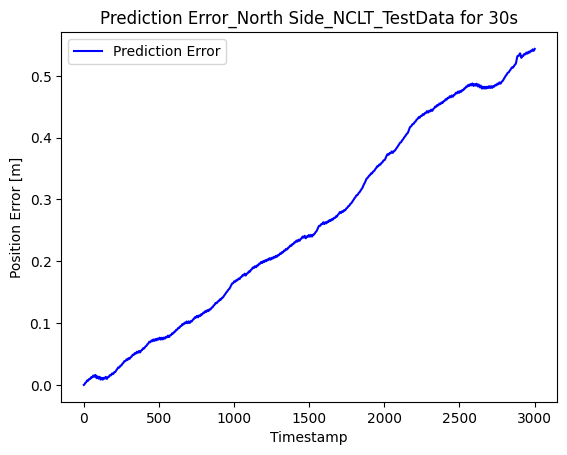

SE: 0.544 m
RMSE: 0.311 m


In [49]:
East_actual_TEST3 = np.array(East_actual_TEST3)
North_actual_TEST3 = np.array(North_actual_TEST3)
East_predicted_TEST3 = np.array(East_predicted_TEST3)
North_predicted_TEST3 = np.array(North_predicted_TEST3)

SE_TEST3 = np.sqrt((North_actual_TEST3 - North_predicted_TEST3) ** 2)
RMSE_TEST3 = np.sqrt(np.mean((North_actual_TEST3 - North_predicted_TEST3) ** 2))

time_steps_TEST3 = np.arange(len(SE_TEST3))

plt.plot(time_steps_TEST3, SE_TEST3, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_North Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

print('SE: {:.3f} m'.format(SE_TEST3[-1]))
print('RMSE: {:.3f} m'.format(RMSE_TEST3))

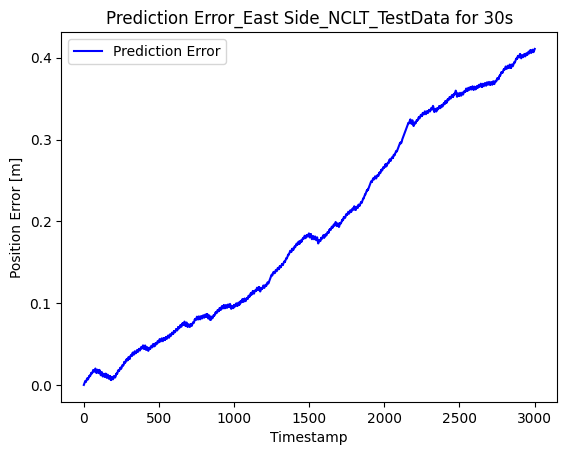

SE: 0.411 m
RMSE: 0.231 m


In [50]:
SE_TEST3 = np.sqrt((East_actual_TEST3 - East_predicted_TEST3) ** 2)
RMSE_TEST3 = np.sqrt(np.mean((East_actual_TEST3 - East_predicted_TEST3) ** 2))

time_steps_TEST3 = np.arange(len(SE_TEST3))

plt.plot(time_steps_TEST3, SE_TEST3, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_East Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

print('SE: {:.3f} m'.format(SE_TEST3[-1]))
print('RMSE: {:.3f} m'.format(RMSE_TEST3))

In [36]:
predicted_Down_TEST2 = rescaled_y_preds_N_E_TEST2[:, 2]
actual_Down_TEST2 = rescaled_y_test_actual_N_E_TEST2[:, 2]

initial_Down = data_TEST2['Down'][70020]
Down_predicted_TEST2 = [initial_Down]
for change in predicted_Down_TEST2:
    new_Down_TEST2 = Down_predicted_TEST2[-1] + change
    Down_predicted_TEST2.append(new_Down_TEST2)

# 실제 Altitude 추정치 계산
Down_actual_TEST2 = [initial_Down]
for change in actual_Down_TEST2:
    new_Down_TEST2 = Down_actual_TEST2[-1] + change
    Down_actual_TEST2.append(new_Down_TEST2)

Down_actual_TEST2 = np.array(Down_actual_TEST2)
Down_predicted_TEST2 = np.array(Down_predicted_TEST2)

In [38]:
predicted_Down_TEST3 = rescaled_y_preds_N_E_TEST3[:, 2]
actual_Down_TEST3 = rescaled_y_test_actual_N_E_TEST3[:, 2]

initial_Down = data_TEST3['Down'][100520]
Down_predicted_TEST3 = [initial_Down]
for change in predicted_Down_TEST3:
    new_Down_TEST3 =Down_predicted_TEST3[-1] + change
    Down_predicted_TEST3.append(new_Down_TEST3)

# 실제 Altitude 추정치 계산
Down_actual_TEST3 = [initial_Down]
for change in actual_Down_TEST3:
    new_Down_TEST3 = Down_actual_TEST3[-1] + change
    Down_actual_TEST3.append(new_Down_TEST3)

Down_actual_TEST3 = np.array(Down_actual_TEST3)
Down_predicted_TEST3 = np.array(Down_predicted_TEST3)

In [40]:
df_P_Course2=pd.DataFrame(North_predicted_TEST2, columns=['North'])
df_P_Course2['East']=East_predicted_TEST2
df_P_Course2['Down']=Down_predicted_TEST2
df_GPS_TEST3.iloc[70020:73022] = df_P_Course2.values


In [41]:
df_P_Course3=pd.DataFrame(North_predicted_TEST3, columns=['North'])
df_P_Course3['East']=East_predicted_TEST3
df_P_Course3['Down']=Down_predicted_TEST3
df_GPS_TEST3.iloc[100520:103522] = df_P_Course3.values

In [42]:
Predict_120122_path = '/content/sample_data/120122_robot/120122_predicted_gps.csv'
df_GPS_TEST3.to_csv(Predict_120122_path, index=False)

**음영구간에서 예측모델로 예측한 값을 사용하여 나타낸 전체 경로**

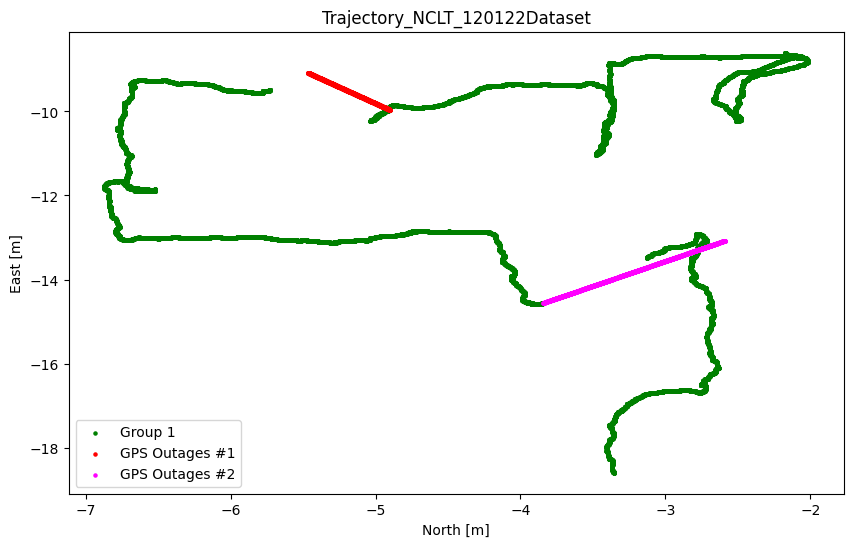

In [51]:
df1 = df_GPS_TEST3.iloc[50000:70020]
df2 = df_GPS_TEST3.iloc[70020:73022]
df3 = df_GPS_TEST3.iloc[73022:100520]
df4 = df_GPS_TEST3.iloc[100520:103522]
df5 = df_GPS_TEST3.iloc[103522:120000]

plt.figure(figsize=(10,6))
plt.scatter(df1['North'], df1['East'], color='green', label='Group 1', s=5)
plt.scatter(df3['North'], df3['East'], color='green', s=5)
plt.scatter(df5['North'], df5['East'], color='green', s=5)

plt.scatter(df2['North'], df2['East'], color='red', label='GPS Outages #1', s=5)
plt.scatter(df4['North'], df4['East'], color='magenta', label='GPS Outages #2', s=5)

plt.title('Trajectory_NCLT_120122Dataset')
plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.legend()
plt.show()

**음영구간 가정을 포함한 전체 경로**

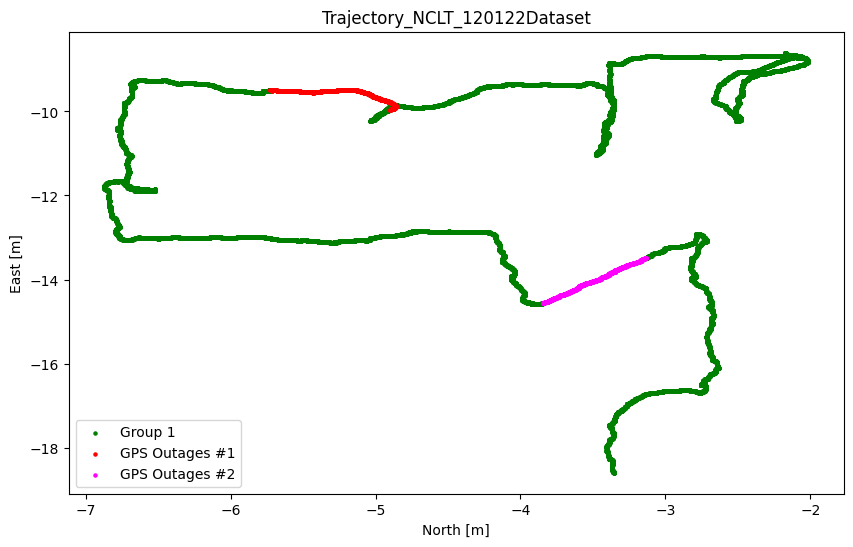

In [52]:
df_GPS = pd.read_csv('/content/sample_data/120122_robot/120122_nedgps.csv', header = None, names = ['North', 'East', 'Down'])

df1 = df_GPS.iloc[50000:70020]
df2 = df_GPS.iloc[70020:73022]
df3 = df_GPS.iloc[73022:100520]
df4 = df_GPS.iloc[100520:103522]
df5 = df_GPS.iloc[103522:120000]

plt.figure(figsize=(10,6))
plt.scatter(df1['North'], df1['East'], color='green', label='Group 1', s=5)
plt.scatter(df3['North'], df3['East'], color='green', s=5)
plt.scatter(df5['North'], df5['East'], color='green', s=5)

plt.scatter(df2['North'], df2['East'], color='red', label='GPS Outages #1', s=5)
plt.scatter(df4['North'], df4['East'], color='magenta', label='GPS Outages #2', s=5)

plt.title('Trajectory_NCLT_120122Dataset')
plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.legend()
plt.show()


In [64]:
pip install folium

**전체경로 mapping(실패)**

In [98]:
import pandas as pd
import folium

df_GPS = pd.read_csv('/content/sample_data/120122_robot/GPS.csv', usecols=[0, 1], header=None, names=['Latitude', 'Longitude'])

df_GPS = df_GPS.dropna()
df1 = df_GPS.iloc[50000:70020]
df2 = df_GPS.iloc[70020:73022]
df3 = df_GPS.iloc[73022:100520]
df4 = df_GPS.iloc[100520:103522]
df5 = df_GPS.iloc[103522:120000]

map_center = [df1.iloc[0]['Latitude'], df1.iloc[0]['Longitude']]

mymap = folium.Map(location=map_center, zoom_start=10)


coordinates1 = df1[['Latitude', 'Longitude']].values.tolist()
coordinates2 = df2[['Latitude', 'Longitude']].values.tolist()
coordinates3 = df3[['Latitude', 'Longitude']].values.tolist()
coordinates4 = df4[['Latitude', 'Longitude']].values.tolist()
coordinates5 = df5[['Latitude', 'Longitude']].values.tolist()
folium.PolyLine(coordinates1, color='blue', weight=2.5, opacity=1).add_to(mymap)
folium.PolyLine(coordinates2, color='red', weight=2.5, opacity=1).add_to(mymap)
folium.PolyLine(coordinates3, color='blue', weight=2.5, opacity=1).add_to(mymap)
folium.PolyLine(coordinates4, color='red', weight=2.5, opacity=1).add_to(mymap)
folium.PolyLine(coordinates5, color='blue', weight=2.5, opacity=1).add_to(mymap)

mymap.save('gps_route.html')